In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from functools import reduce

# Experimental setup

In [2]:
with open("experiments.json","r") as f:
    exp = json.load(f)
    
    experiments = exp["experiments"]
    experiment_ids = exp["experiment_ids"]

splice_types = ["A3SS","A5SS","MXE","RI","SE"]

# Transcripts to genes

In [3]:
t2g = pd.read_csv("../data/intermediate/sleuth_diff/ensembl_t2g.csv",
                  names=["transcript_id", "gene_id", "gene_name","entrez_id","duplicate"]
                  )
t2g = t2g.dropna()
t2g = t2g.astype(str)

t2g["format_transcript_id"] = t2g["gene_name"] + "_" + t2g["transcript_id"]
t2g["format_gene_id"] = t2g["gene_name"] + "_" + t2g["gene_id"]
t2g["gene_id_stable"] = t2g["gene_id"].str.split(".").str[0]

gene_name_map = dict(zip(t2g["gene_id_stable"], t2g["gene_name"]))


/Users/khu/anaconda3/envs/cenv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0,4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Merge splice types

In [4]:
def compute_medians(splices, experiment):
    splices["control_median"] = splices[experiments[experiment]
                                        [0]].median(axis=1)
    splices["treatment_median"] = splices[experiments[experiment]
                                          [1]].median(axis=1)
    splices["median_foldchange"] = splices["treatment_median"] / \
        splices["control_median"]


def concat_cols(df, cols, delim):
    cols_str = [df[x].astype(str) for x in cols]

    return reduce(lambda a, b: a + delim + b, cols_str)


def load_splices(experiment):

    controls = experiments[experiment][0]
    treatments = experiments[experiment][1]

    A3SS = pd.read_csv("../data/raw/rmats_output/"+experiment +
                       "/A3SS.MATS.JC.txt", sep="\t", index_col=0)
    A5SS = pd.read_csv("../data/raw/rmats_output/"+experiment +
                       "/A5SS.MATS.JC.txt", sep="\t", index_col=0)
    MXE = pd.read_csv("../data/raw/rmats_output/"+experiment +
                      "/MXE.MATS.JC.txt", sep="\t", index_col=0)
    RI = pd.read_csv("../data/raw/rmats_output/"+experiment +
                     "/RI.MATS.JC.txt", sep="\t", index_col=0)
    SE = pd.read_csv("../data/raw/rmats_output/"+experiment +
                     "/SE.MATS.JC.txt", sep="\t", index_col=0)

    A3SS["gene_id"] = A3SS["geneSymbol"] + "_" + A3SS["GeneID"]
    A5SS["gene_id"] = A5SS["geneSymbol"] + "_" + A5SS["GeneID"]
    MXE["gene_id"] = MXE["geneSymbol"] + "_" + MXE["GeneID"]
    RI["gene_id"] = RI["geneSymbol"] + "_" + RI["GeneID"]
    SE["gene_id"] = SE["geneSymbol"] + "_" + SE["GeneID"]

    A3SS["exon_id"] = concat_cols(
        A3SS, ['chr', 'longExonStart_0base',
               'longExonEnd', 'shortES', 'shortEE', 'flankingES', 'flankingEE'], "_")
    A5SS["exon_id"] = concat_cols(
        A5SS, ['chr', 'longExonStart_0base',
               'longExonEnd', 'shortES', 'shortEE', 'flankingES', 'flankingEE'], "_")
    MXE["exon_id"] = concat_cols(
        MXE, ['chr', '1stExonStart_0base',
              '1stExonEnd', '2ndExonStart_0base', '2ndExonEnd', 'upstreamES',
              'upstreamEE', 'downstreamES', 'downstreamEE'], "_")
    RI["exon_id"] = concat_cols(
        RI, ['chr', 'riExonStart_0base',
             'riExonEnd', 'upstreamES', 'upstreamEE', 'downstreamES', 'downstreamEE'], "_")
    SE["exon_id"] = concat_cols(
        SE, ['chr', 'exonStart_0base', 'exonEnd',
             'upstreamES', 'upstreamEE', 'downstreamES', 'downstreamEE'], "_")

    A3SS["exon_gene_id"] = A3SS["gene_id"] + "_" + A3SS["exon_id"]
    A5SS["exon_gene_id"] = A5SS["gene_id"] + "_" + A5SS["exon_id"]
    MXE["exon_gene_id"] = MXE["gene_id"] + "_" + MXE["exon_id"]
    RI["exon_gene_id"] = RI["gene_id"] + "_" + RI["exon_id"]
    SE["exon_gene_id"] = SE["gene_id"] + "_" + SE["exon_id"]

    A3SS = A3SS.set_index("exon_gene_id")
    A5SS = A5SS.set_index("exon_gene_id")
    MXE = MXE.set_index("exon_gene_id")
    RI = RI.set_index("exon_gene_id")
    SE = SE.set_index("exon_gene_id")

    A3SS["splice_type"] = "A3SS"
    A5SS["splice_type"] = "A5SS"
    MXE["splice_type"] = "MXE"
    RI["splice_type"] = "RI"
    SE["splice_type"] = "SE"

    merged_cols = ["splice_type", "GeneID", "geneSymbol",
                   "PValue", "FDR", "IncLevel1", "IncLevel2", "gene_id"]

    merged_splices = pd.concat([A3SS[merged_cols],
                                A5SS[merged_cols],
                                MXE[merged_cols],
                                RI[merged_cols],
                                SE[merged_cols],
                                ], axis=0)

    def nan_replace(x): return x.replace("NA", "nan")

    merged_splices["IncLevel1"] = merged_splices["IncLevel1"].apply(
        nan_replace)
    merged_splices["IncLevel2"] = merged_splices["IncLevel2"].apply(
        nan_replace)

    control_split = merged_splices["IncLevel1"].str.split(",").str
    treatment_split = merged_splices["IncLevel2"].str.split(",").str

    for i in range(len(controls)):
        merged_splices[controls[i]] = control_split[i].astype(np.float32)

    for i in range(len(treatments)):
        merged_splices[treatments[i]] = treatment_split[i].astype(np.float32)

    merged_splices = merged_splices.drop(["IncLevel1", "IncLevel2"], axis=1)

    compute_medians(merged_splices, experiment)

    merged_splices = merged_splices.sort_values(by="FDR")

    return merged_splices

In [5]:
rpl22_oe_rmats = load_splices("rpl22_oe")
rpl22l1_oe_rmats = load_splices("rpl22l1_oe")
rpl22l1_kd1_rmats = load_splices("rpl22l1_kd1")
rpl22l1_kd2_rmats = load_splices("rpl22l1_kd2")
rpl22_a_ko1_rmats = load_splices("rpl22_a_ko1")
rpl22_a_ko2_rmats = load_splices("rpl22_a_ko2")
rpl22_b_ko1_rmats = load_splices("rpl22_b_ko1")
rpl22_b_ko2_rmats = load_splices("rpl22_b_ko2")

In [6]:
rpl22_oe_rmats.to_csv("../data/processed/rmats_merge/rpl22_oe.txt",sep="\t")
rpl22l1_oe_rmats.to_csv("../data/processed/rmats_merge/rpl22l1_oe.txt",sep="\t")
rpl22l1_kd1_rmats.to_csv("../data/processed/rmats_merge/rpl22l1_kd1.txt",sep="\t")
rpl22l1_kd2_rmats.to_csv("../data/processed/rmats_merge/rpl22l1_kd2.txt",sep="\t")
rpl22_a_ko1_rmats.to_csv("../data/processed/rmats_merge/rpl22_a_ko1.txt",sep="\t")
rpl22_a_ko2_rmats.to_csv("../data/processed/rmats_merge/rpl22_a_ko2.txt",sep="\t")
rpl22_b_ko1_rmats.to_csv("../data/processed/rmats_merge/rpl22_b_ko1.txt",sep="\t")
rpl22_b_ko2_rmats.to_csv("../data/processed/rmats_merge/rpl22_b_ko2.txt",sep="\t")

rpl22_oe_rmats.to_hdf("../data/processed/rmats_merge/rpl22_oe.h5",key="rmats",mode="w")
rpl22l1_oe_rmats.to_hdf("../data/processed/rmats_merge/rpl22l1_oe.h5",key="rmats",mode="w")
rpl22l1_kd1_rmats.to_hdf("../data/processed/rmats_merge/rpl22l1_kd1.h5",key="rmats",mode="w")
rpl22l1_kd2_rmats.to_hdf("../data/processed/rmats_merge/rpl22l1_kd2.h5",key="rmats",mode="w")
rpl22_a_ko1_rmats.to_hdf("../data/processed/rmats_merge/rpl22_a_ko1.h5",key="rmats",mode="w")
rpl22_a_ko2_rmats.to_hdf("../data/processed/rmats_merge/rpl22_a_ko2.h5",key="rmats",mode="w")
rpl22_b_ko1_rmats.to_hdf("../data/processed/rmats_merge/rpl22_b_ko1.h5",key="rmats",mode="w")
rpl22_b_ko2_rmats.to_hdf("../data/processed/rmats_merge/rpl22_b_ko2.h5",key="rmats",mode="w")

# Pull out SE events

In [53]:
def load_se(experiment):
    se = pd.read_csv("../data/raw/rmats_output/"+ experiment +
                     "/SE.MATS.JC.txt", sep="\t", index_col=0)
    
    se["exon_length"] = se["exonEnd"]-se["exonStart_0base"]
    
    se["exon_id"] = concat_cols(
        se, ['chr','exonStart_0base', 'exonEnd',
       'upstreamES', 'upstreamEE', 'downstreamES', 'downstreamEE'], "_")
    
    se = se.set_index("exon_id")
    se = se.sort_values(by="FDR")
    
    return se

rpl22_oe_se = load_se("rpl22_oe")
rpl22l1_oe_se = load_se("rpl22l1_oe")
rpl22l1_kd1_se = load_se("rpl22l1_kd1")
rpl22l1_kd2_se = load_se("rpl22l1_kd2")
rpl22_a_ko1_se = load_se("rpl22_a_ko1")
rpl22_a_ko2_se = load_se("rpl22_a_ko2")
rpl22_b_ko1_se = load_se("rpl22_b_ko1")
rpl22_b_ko2_se = load_se("rpl22_b_ko2")

In [205]:
rpl22_a_exons = (rpl22_a_ko1_se["FDR"] < 0.0001) & (
    (rpl22_a_ko2_se["FDR"] < 0.0001))

# rpl22_b_exons = (rpl22_b_ko1_se["FDR"] < 0.0001) & (
#     (rpl22_b_ko2_se["FDR"] < 0.0001))

# exon_filter = rpl22l1_oe_se["FDR"] < 0.0001

exon_filter = rpl22_a_exons

padding = 100
max_len = 1000

exon_set = rpl22_a_ko1_se[["chr", "exonStart_0base",
                           "exonEnd", "strand", "exon_length","geneSymbol"]].copy(deep=True)
exon_set = exon_set[exon_set["exon_length"] <= max_len]

exon_set["chr"] = exon_set["chr"].apply(lambda x: x[3:])
exon_set["start"] = exon_set["exonStart_0base"] - padding
exon_set["end"] = exon_set["exonEnd"] + padding
exon_set["id"] = exon_set.index
exon_set["id"] = exon_set["geneSymbol"] + "_" + exon_set["id"]

pos_exons = exon_set[exon_filter]
neg_exons = exon_set[~exon_filter].sample(5000)

pos_exons[["chr", "start", "end", "id", "exon_length", "strand"]].to_csv(
    "../data/intermediate/rpl22_a_ko1_se_pos.bed", sep="\t", header=False, index=False)
neg_exons[["chr", "start", "end", "id", "exon_length", "strand"]].to_csv(
    "../data/intermediate/rpl22_a_ko1_se_neg.bed", sep="\t", header=False, index=False)

/Users/khu/anaconda3/envs/cenv/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/khu/anaconda3/envs/cenv/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [206]:
!bedtools getfasta -s -name \
    -fi ../data/raw/reference/hg19.fa -bed \
    ../data/intermediate/rpl22_a_ko1_se_pos.bed \
    > ../data/intermediate/rpl22_a_ko1_se_pos.fasta

!bedtools getfasta -s -name \
    -fi ../data/raw/reference/hg19.fa -bed \
    ../data/intermediate/rpl22_a_ko1_se_neg.bed \
    > ../data/intermediate/rpl22_a_ko1_se_neg.fasta

In [199]:
res = pd.read_csv("/Users/khu/Desktop/lsgkm-master/bin/test.cvpred.txt",sep="\t",names=["id","pred","true","fold"])


In [200]:
res[res["pred"]>-0.5]

,id,pred,true,fold
7,TRA2A_chr7_23561739_23562051_23561325_23561459...,0.302410,1,2
14,CD44_chr11_35222628_35222742_35211381_35211612...,0.072604,1,2
18,TRA2A_chr7_23561750_23562051_23561325_23561459...,0.025518,1,1
22,RPS24_chr10_79799958_79799983_79796951_7979706...,-0.036746,1,1
23,MAGOHB_chr12_10765238_10765577_10763220_107632...,-0.344366,1,1
40,MAGOHB_chr12_10765413_10765577_10763220_107632...,-0.358249,1,2
46,EIF4A1_chr17_7481544_7481562_7481144_7481234_7...,-0.119349,1,2
49,STK40_chr1_36833448_36833685_36826821_36826941...,0.059753,1,2
55,DMKN_chr19_35997027_35997087_35996840_35996888...,-0.097584,1,2
57,RPS24_chr10_79799961_79799983_79796951_7979706...,-0.025333,1,2


In [202]:
cv_res = res[res["fold"]==1]

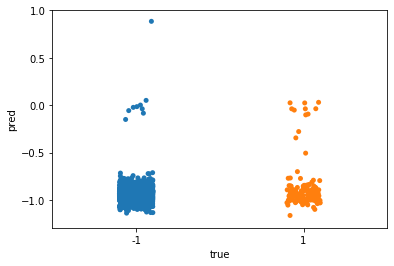

In [203]:
sns.stripplot(cv_res["true"],cv_res["pred"])

In [ ]:
sns.stripplot(cv_res["true"],cv_res["pred"])

In [192]:
scores = pd.read_csv("/Users/khu/Desktop/lsgkm-master/bin/scores.txt",sep="\t",names=["kmer","score"])

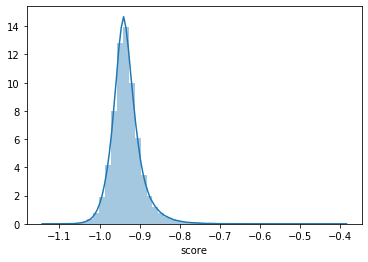

In [193]:
sns.distplot(scores["score"])

In [194]:
scores.sort_values(by="score")

,kmer,score
492032,TAAAAGAAAA,-1.136470
1027,AAAACAAAAT,-1.130200
12412,AAATAATAAA,-1.114080
411570,GAGCAGCTGC,-1.112740
524762,TTTCTTAAAA,-1.111060
448742,GCTGGCTGCC,-1.110480
259711,CAGGACCTCC,-1.108260
428346,GCAGCCAGCA,-1.107630
148937,AGCTCCTGGA,-1.105170
382287,CTGGGGCTGC,-1.103610
